<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Read-data-from-disk" data-toc-modified-id="Read-data-from-disk-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data from disk</a></span></li><li><span><a href="#Align-the-spectra-into-consistent-energy-bins-across-available-data" data-toc-modified-id="Align-the-spectra-into-consistent-energy-bins-across-available-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Align the spectra into consistent energy bins across available data</a></span></li><li><span><a href="#Select-the-most-highly-sampled-examples" data-toc-modified-id="Select-the-most-highly-sampled-examples-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Select the most highly sampled examples</a></span></li><li><span><a href="#Trim-and-Visualize" data-toc-modified-id="Trim-and-Visualize-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Trim and Visualize</a></span></li><li><span><a href="#Simple-Models" data-toc-modified-id="Simple-Models-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Simple Models</a></span><ul class="toc-item"><li><span><a href="#PCA-(Unsupervised)" data-toc-modified-id="PCA-(Unsupervised)-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>PCA (Unsupervised)</a></span></li><li><span><a href="#LDA-(Supervised)" data-toc-modified-id="LDA-(Supervised)-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>LDA (Supervised)</a></span></li></ul></li></ul></li><li><span><a href="#Soft-PLS-DA" data-toc-modified-id="Soft-PLS-DA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Soft PLS-DA</a></span><ul class="toc-item"><li><span><a href="#Optimize-a-Model" data-toc-modified-id="Optimize-a-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Optimize a Model</a></span></li><li><span><a href="#Explanations" data-toc-modified-id="Explanations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Explanations</a></span></li></ul></li><li><span><a href="#SIMCA" data-toc-modified-id="SIMCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SIMCA</a></span><ul class="toc-item"><li><span><a href="#Optimize-models" data-toc-modified-id="Optimize-models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize models</a></span></li><li><span><a href="#Explanations" data-toc-modified-id="Explanations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explanations</a></span></li></ul></li></ul></div>

In [ ]:
# Alternative preprocessing, including:
# * SavGol filtering
# * (Pareto) scaling
# * Variance Thresholding

# Check data in the online sharepoint site
# SHAP
# Learning curves?

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/chemometrics.git
    !cd chemometrics; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import chemometrics

import matplotlib.pyplot as plt

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from chemometrics.utils import plot_learning_curve, plot_confusion_matrix

shap.initjs()

# Load Data

In [170]:
import utils, os

## Read data from disk

In [263]:
head = "./spefiles"

spectra = []
energies = []
y = []

for root, subdirectories, files in os.walk(head):
    for file in files:
        raw, bins = utils.read_spe(os.path.join(root, file), 
                                   coarsen=1, # Coarsen after alignment
                                   convert=True, # Convert from bin # to energy (eV)
                                   annihilation=False
                                  ) # Converts
        spectra.append(raw)
        energies.append(bins)
        assert(len(subdirectories) == 0)
        y.append(root.split(head+'/')[1])
spectra = np.array(spectra)
energies = np.array(energies)
y = np.array(y)

## Align the spectra into consistent energy bins across available data

In [277]:
lowest_energy = np.min(energies)
highest_energy = np.max(energies)
nbins = int(spectra.shape[1])
dbin = (highest_energy - lowest_energy) / nbins

# [LB c0 | c1 | c2 | ... | cn UB]
bin_centers = np.arange(nbins)*dbin + dbin/2.0 + lowest_energy

def align(s, e):
    aligned = np.zeros(nbins, dtype=np.float64)
    
    def get_bin(e):
        return np.array(np.floor((e-lowest_energy)/dbin), dtype=int)
    
    for value, idx in zip(s, get_bin(e)):
        i = int(idx)
        if i == nbins:
            i -= 1
        aligned[i] += value
    return aligned

In [289]:
aligned_spectra = []
coarsen = 4

for s,e in tqdm.tqdm(zip(spectra, energies)):
    # Align
    a_ = align(s, e)
    
    # Coarsen
    c_ = np.array([np.sum(a_[coarsen*start:coarsen*(start+1)]) 
              for start in range(len(a_)//coarsen)], dtype=np.float64)
    aligned_spectra.append(c_)
    
aligned_spectra = np.array(aligned_spectra)
aligned_centers = np.array([np.sum(bin_centers[coarsen*start:coarsen*(start+1)]) 
              for start in range(len(bin_centers)//coarsen)], dtype=np.float64)

330it [00:14, 23.40it/s]


## Select the most highly sampled examples

In [292]:
df = pd.DataFrame(data=aligned_spectra)
df['label'] = y

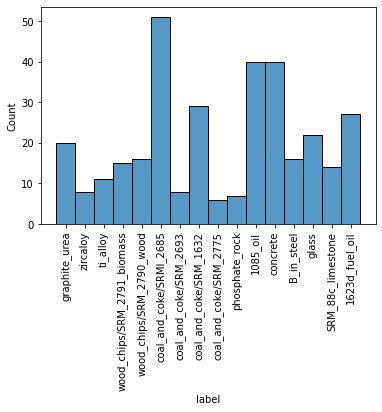

In [293]:
plt.figure()
sns.histplot(df, x='label')
_ = plt.xticks(rotation=90)

In [294]:
# To train authentication models we really need a good number of examples.  So let's set a chosen minimum number 
# of observations for a class and only work with those.  The others we can always use others as "foreign" objects.

In [295]:
cats, counts = np.unique(df['label'].values, return_counts=True)

In [296]:
min_counts = 20
df_min = df[df['label'].apply(lambda x: x in cats[counts >= min_counts])]
df_foreign = df[df['label'].apply(lambda x: x in cats[counts < min_counts])]

In [297]:
np.unique(df_min['label'], return_counts=True)

(array(['1085_oil', '1623d_fuel_oil', 'coal_and_coke/SRM_1632',
        'coal_and_coke/SRMl_2685', 'concrete', 'glass', 'graphite_urea'],
       dtype=object),
 array([40, 27, 29, 51, 40, 22, 20]))

In [298]:
np.unique(df_foreign['label'], return_counts=True)

(array(['B_in_steel', 'SRM_88c_limestone', 'coal_and_coke/SRM_2693',
        'coal_and_coke/SRM_2775', 'phosphate_rock', 'ti_alloy',
        'wood_chips/SRM_2790_wood', 'wood_chips/SRM_2791_biomass',
        'zircaloy'], dtype=object),
 array([16, 14,  8,  6,  7, 11, 16, 15,  8]))

## Trim and Visualize

In [ ]:
# Measurements tend to be unreliable at low energy, so choose to drop off first bins
drop = 30 # Number of bins to drop off at the beginning

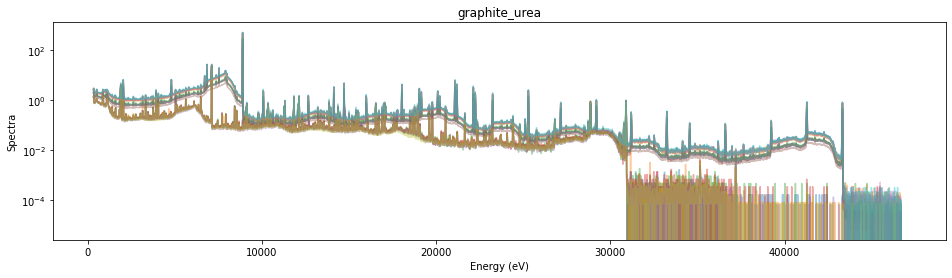

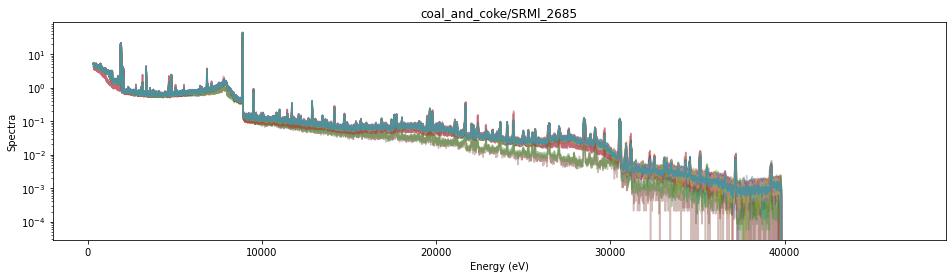

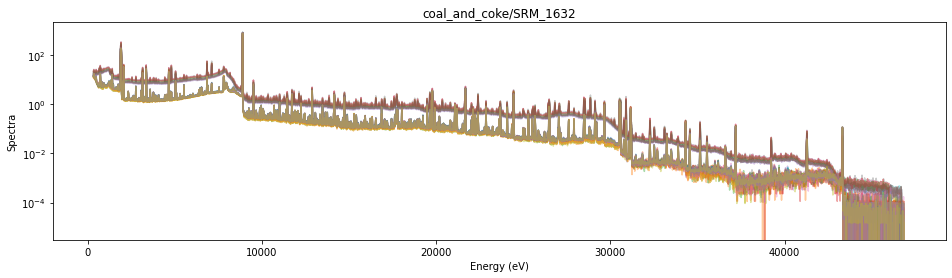

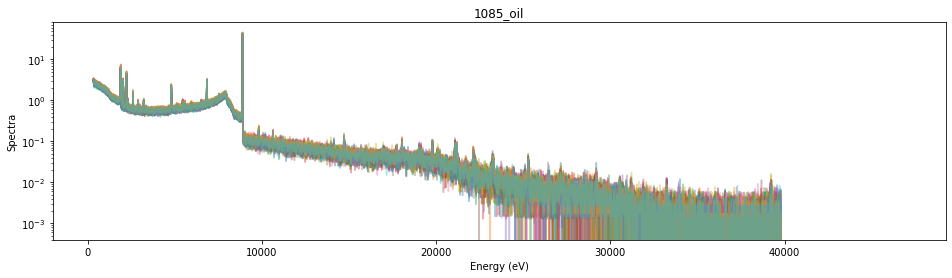

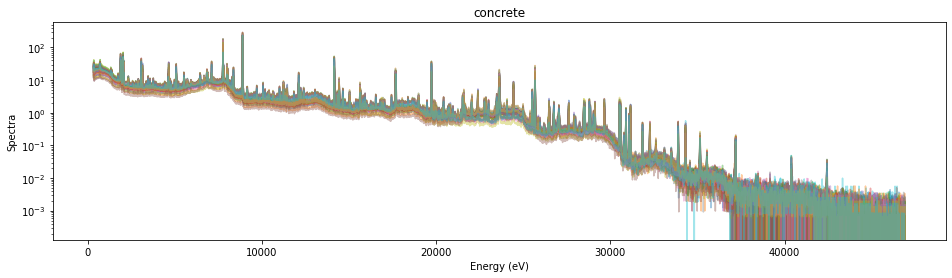

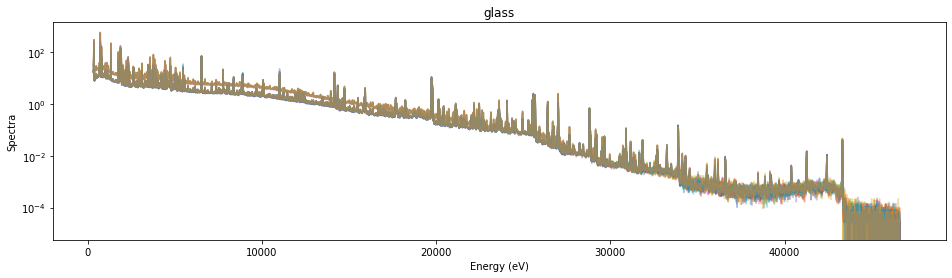

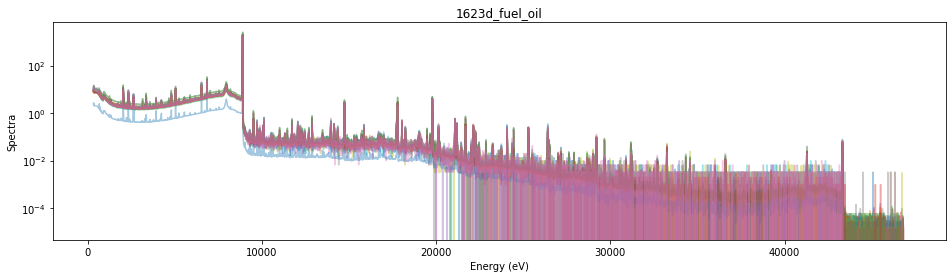

In [313]:
for label in df_min['label'].unique():
    plt.figure(figsize=(16,4))
    y_ = df_min[df_min['label'] == label].drop('label', axis=1).values
    _ = [plt.plot(aligned_centers[drop:], a[drop:], '-', alpha=0.4) for a in y_]
    plt.yscale('log')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Spectra')
    plt.title(label)

In [318]:
X_train, X_test, y_train, y_test = train_test_split(df_min.drop(np.arange(drop).tolist()+['label'], axis=1).values, 
                                                    df_min['label'].values, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=df_min['label'].values
                                                   )

In [320]:
X_foreign = df_foreign.drop(np.arange(drop).tolist()+['label'], axis=1).values
y_foreign = df_foreign['label'].values

## Simple Models

### PCA (Unsupervised)

In [321]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [322]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


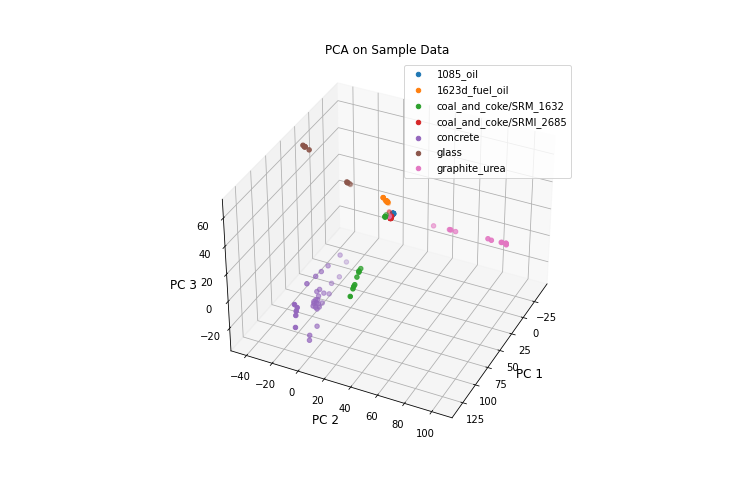

In [325]:
pca = PCA(n_components=3)
ss = StandardScaler()
X_proj = pca.fit_transform(ss.fit_transform(X_train))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_ in np.unique(y_train):
    mask = y_train == class_
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=class_)
ax.legend(loc='best')
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_zlabel('PC 3', fontsize=12)
ax.set_title('PCA on Sample Data', fontsize=12)
ax.view_init(elev=20., azim=-45)

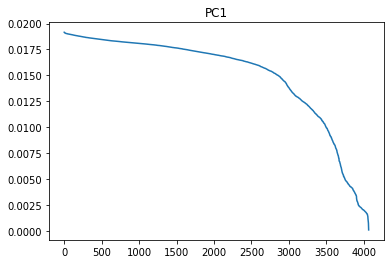

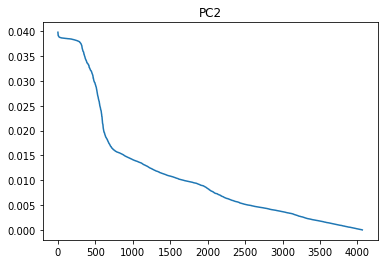

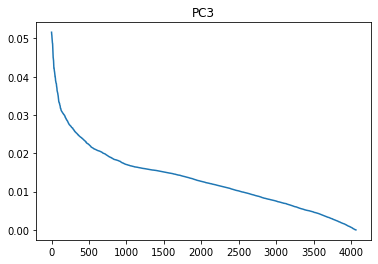

In [330]:
# Most "important" spectral readings from start - index of ~ 3000 for PC1
# Other PCs mostly focus on using progessively lower energy readings.

%matplotlib inline
for i in range(3):
    plt.figure()
    plt.title('PC{}'.format(i+1))
    comps = np.array(sorted(zip(np.arange(X_train.shape[1]), 
                                np.abs(pca.components_[i])), 
                            key=lambda x:np.abs(x[1]), 
                            reverse=True))
    plt.plot(comps[:,1])

### LDA (Supervised)

In [337]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [338]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


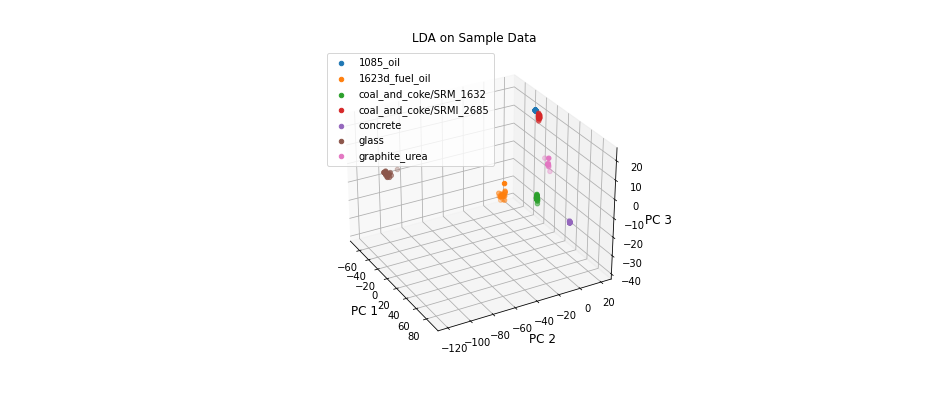

In [339]:
lda = LDA(n_components=3, store_covariance=True)
ss = StandardScaler()
X_proj = lda.fit_transform(ss.fit_transform(X_train), y_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_ in np.unique(y_train):
    mask = y_train == class_
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=class_)
ax.legend(loc='best')
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_zlabel('PC 3', fontsize=12)
ax.set_title('LDA on Sample Data', fontsize=12)
ax.view_init(elev=20., azim=-45)

In [ ]:
# These samples are very different and quite easy to separate with discriminant models.

# Soft PLS-DA

In [346]:
from chemometrics.classifier.plsda import PLSDA

## Optimize a Model

In [347]:
# Let's optimize a PLS-DA model based on its total efficiency (TEFF). Data scaling is handled
# internally via the scale_x hyperparameter so we don't need additional step initially, unless
# you want to add this for some reason.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'plsda__n_components':np.arange(1, min_counts/2, dtype=int),
    'plsda__alpha': [0.05], 
    'plsda__scale_x': [True, False], 
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=3, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)


24 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "../../../chemometrics/classifier/plsda.py", line 323, in fit
    np.linalg.cholesky(self.__S_[i])
  File "<__array_function__ internals>", line 6, in cholesky
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 763, in cholesky
    r = gufunc(a, signature=signature, extobj=extobj)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 91, in _raise_linalgerror_nonposdef
    raise LinAlgError("Matrix is not positive definite")
numpy.linalg.LinAlgError: Matrix is not positive definite

Durin

In [348]:
gs.score(X_train, y_train)

0.9609876522409447

In [349]:
gs.score(X_test, y_test) # Quite good!

0.9325048082403138

In [350]:
gs.best_params_

{'plsda__alpha': 0.05, 'plsda__n_components': 7, 'plsda__scale_x': False}

In [351]:
# Were their any outliers detected at the given gamma=0.01? 
np.any(gs.best_estimator_.named_steps['plsda'].check_outliers())
# Might consider iteratively "cleaning" the dataset as in Rodionova OY., Pomerantsev AL. 
# "Detection of Outliers in Projection-Based Modeling", Anal. Chem. 2020, 92, 2656−2664.

True

In [352]:
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_test),
    y_test
)

In [353]:
df

,1085_oil,1623d_fuel_oil,coal_and_coke/SRM_1632,coal_and_coke/SRMl_2685,concrete,glass,graphite_urea,UNKNOWN
1085_oil,7,0,0,0,0,0,0,1
1623d_fuel_oil,0,5,0,0,0,0,0,1
coal_and_coke/SRM_1632,0,0,4,0,0,0,0,2
coal_and_coke/SRMl_2685,0,0,0,9,0,0,0,1
concrete,0,0,0,0,8,0,0,0
glass,0,0,0,0,0,3,0,1
graphite_urea,0,0,0,0,0,0,4,0


In [355]:
CSNS

1085_oil                   0.875000
1623d_fuel_oil             0.833333
coal_and_coke/SRM_1632     0.666667
coal_and_coke/SRMl_2685    0.900000
concrete                   1.000000
glass                      0.750000
graphite_urea              1.000000
dtype: float64

In [356]:
CSPS

1085_oil                   1.0
1623d_fuel_oil             1.0
coal_and_coke/SRM_1632     1.0
coal_and_coke/SRMl_2685    1.0
concrete                   1.0
glass                      1.0
graphite_urea              1.0
dtype: float64

In [357]:
# Excellent specificity! Problems are purely from sensitivity (unknowns instead of true class), but recall that
# we fixed alpha = 0.05 so we are always going to have some of that.  This is understandable.  

In [358]:
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_train),
    y_train
)

In [359]:
df

,1085_oil,1623d_fuel_oil,coal_and_coke/SRM_1632,coal_and_coke/SRMl_2685,concrete,glass,graphite_urea,UNKNOWN
1085_oil,30,0,0,0,0,0,0,2
1623d_fuel_oil,0,20,0,0,0,0,0,1
coal_and_coke/SRM_1632,0,0,21,0,0,0,0,2
coal_and_coke/SRMl_2685,0,0,0,34,0,0,0,7
concrete,0,0,0,0,32,0,0,0
glass,0,0,0,0,0,18,0,0
graphite_urea,0,0,0,0,0,0,14,2


In [360]:
CSNS

1085_oil                   0.937500
1623d_fuel_oil             0.952381
coal_and_coke/SRM_1632     0.913043
coal_and_coke/SRMl_2685    0.829268
concrete                   1.000000
glass                      1.000000
graphite_urea              0.875000
dtype: float64

In [361]:
CSPS

1085_oil                   1.0
1623d_fuel_oil             1.0
coal_and_coke/SRM_1632     1.0
coal_and_coke/SRMl_2685    1.0
concrete                   1.0
glass                      1.0
graphite_urea              1.0
dtype: float64

In [362]:
# Let's consider the foreign objects
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_foreign),
    y_foreign
)

In [363]:
df # PERFECT performance!

,1085_oil,1623d_fuel_oil,coal_and_coke/SRM_1632,coal_and_coke/SRMl_2685,concrete,glass,graphite_urea,UNKNOWN
B_in_steel,0,0,0,0,0,0,0,16
SRM_88c_limestone,0,0,0,0,0,0,0,14
coal_and_coke/SRM_2693,0,0,0,0,0,0,0,8
coal_and_coke/SRM_2775,0,0,0,0,0,0,0,6
phosphate_rock,0,0,0,0,0,0,0,7
ti_alloy,0,0,0,0,0,0,0,11
wood_chips/SRM_2790_wood,0,0,0,0,0,0,0,16
wood_chips/SRM_2791_biomass,0,0,0,0,0,0,0,15
zircaloy,0,0,0,0,0,0,0,8


## Explanations

# SIMCA

In [364]:
from chemometrics.classifier.simca import SIMCA_Classifier

In [365]:
# The previous example of PLS-DA trains a single model to distinguish between all known classes, and possibly
# the unknown. An authentication model trains on a single class and uses the others (if provided) as 
# background to check the model's efficiency, but is not used during training.

## Optimize models

In [ ]:
# Add preprocessor to remove dims with variance of 0
# Other preprocessing also possible

In [375]:
# Now let's optimize a SIMCA model based on its total efficiency (TEFF). Data scaling is handled
# internally via the scale_x hyperparameter so we don't need additional step initially, unless
# you want to add this for some reason.

models = {}

for target in np.unique(y_train):
    pipeline = imblearn.pipeline.Pipeline(steps=[
        # Insert other preprocessing steps here...
        # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=target, 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    param_grid = [{
        # 'smote__k_enn':[1, 2, 3],
        # 'smote__k_smote':[1, 3, 3],
        # 'smote__kind_sel_enn':['all', 'mode'],
        'simca__n_components':np.arange(1, min_counts/2, dtype=int),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True, False] # True seems to cause inf because division by 0, I believe
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=3, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(X_train, y_train)
    
    models[target] = gs
    
    print(target, gs.best_params_)


27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

1085_oil {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

1623d_fuel_oil {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

coal_and_coke/SRM_1632 {'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

coal_and_coke/SRMl_2685 {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}
concrete {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

glass {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}
graphite_urea {'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit(

In [376]:
for target in models:
    print('Best SIMCA model for {} has TEFF (train) = {}, TEFF (test) = {}'.format(
        target,
        '%.4f'%models[target].score(X_train, y_train),
        '%.4f'%models[target].score(X_test, y_test))
    )

Best SIMCA model for 1085_oil has TEFF (train) = 0.9843, TEFF (test) = 0.9354
Best SIMCA model for 1623d_fuel_oil has TEFF (train) = 0.9258, TEFF (test) = 0.9129
Best SIMCA model for coal_and_coke/SRM_1632 has TEFF (train) = 1.0000, TEFF (test) = 1.0000
Best SIMCA model for coal_and_coke/SRMl_2685 has TEFF (train) = 0.9500, TEFF (test) = 1.0000
Best SIMCA model for concrete has TEFF (train) = 0.9843, TEFF (test) = 1.0000
Best SIMCA model for glass has TEFF (train) = 0.9428, TEFF (test) = 0.7071
Best SIMCA model for graphite_urea has TEFF (train) = 0.9354, TEFF (test) = 1.0000


In [377]:
# All models have PERFECT performance on other foreign objects
for target in models:
    print('%.4f'%models[target].score(X_foreign, y_foreign), target)

1.0000 1085_oil
1.0000 1623d_fuel_oil
1.0000 coal_and_coke/SRM_1632
1.0000 coal_and_coke/SRMl_2685
1.0000 concrete
1.0000 glass
1.0000 graphite_urea


In [378]:
# All are quite good! Again, glass is not great, but ok.

In [379]:
class_specificity = []
for k in sorted(models.keys()):
    _ = models[k].best_estimator_.named_steps['simca'].score(X_train, y_train)
    csps = models[k].best_estimator_.named_steps['simca'].CSPS
    row = []
    for x in sorted(np.unique(y_train)):
        if x == k:
            row.append(-1)
        else:
            row.append(csps[x])
    print('Optimal number of dims for {} : {}'.format(k, models[k].best_params_['simca__n_components']))
    class_specificity.append(row)

Optimal number of dims for 1085_oil : 1
Optimal number of dims for 1623d_fuel_oil : 1
Optimal number of dims for coal_and_coke/SRM_1632 : 2
Optimal number of dims for coal_and_coke/SRMl_2685 : 1
Optimal number of dims for concrete : 1
Optimal number of dims for glass : 1
Optimal number of dims for graphite_urea : 2


In [380]:
# Note how all are very low D - this is consistent with the early PCA results showing that PCA on its own
# was able to separate classes in an unsupervised fashion.

In [381]:
pd.DataFrame(data=class_specificity, columns=sorted(np.unique(y_train)), index=sorted(models.keys()))

,1085_oil,1623d_fuel_oil,coal_and_coke/SRM_1632,coal_and_coke/SRMl_2685,concrete,glass,graphite_urea
1085_oil,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
1623d_fuel_oil,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
coal_and_coke/SRM_1632,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
coal_and_coke/SRMl_2685,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
concrete,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
glass,1.0,1.0,1.0,1.0,1.0,-1.0,1.0
graphite_urea,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


In [373]:
%matplotlib notebook

<IPython.core.display.Javascript object>


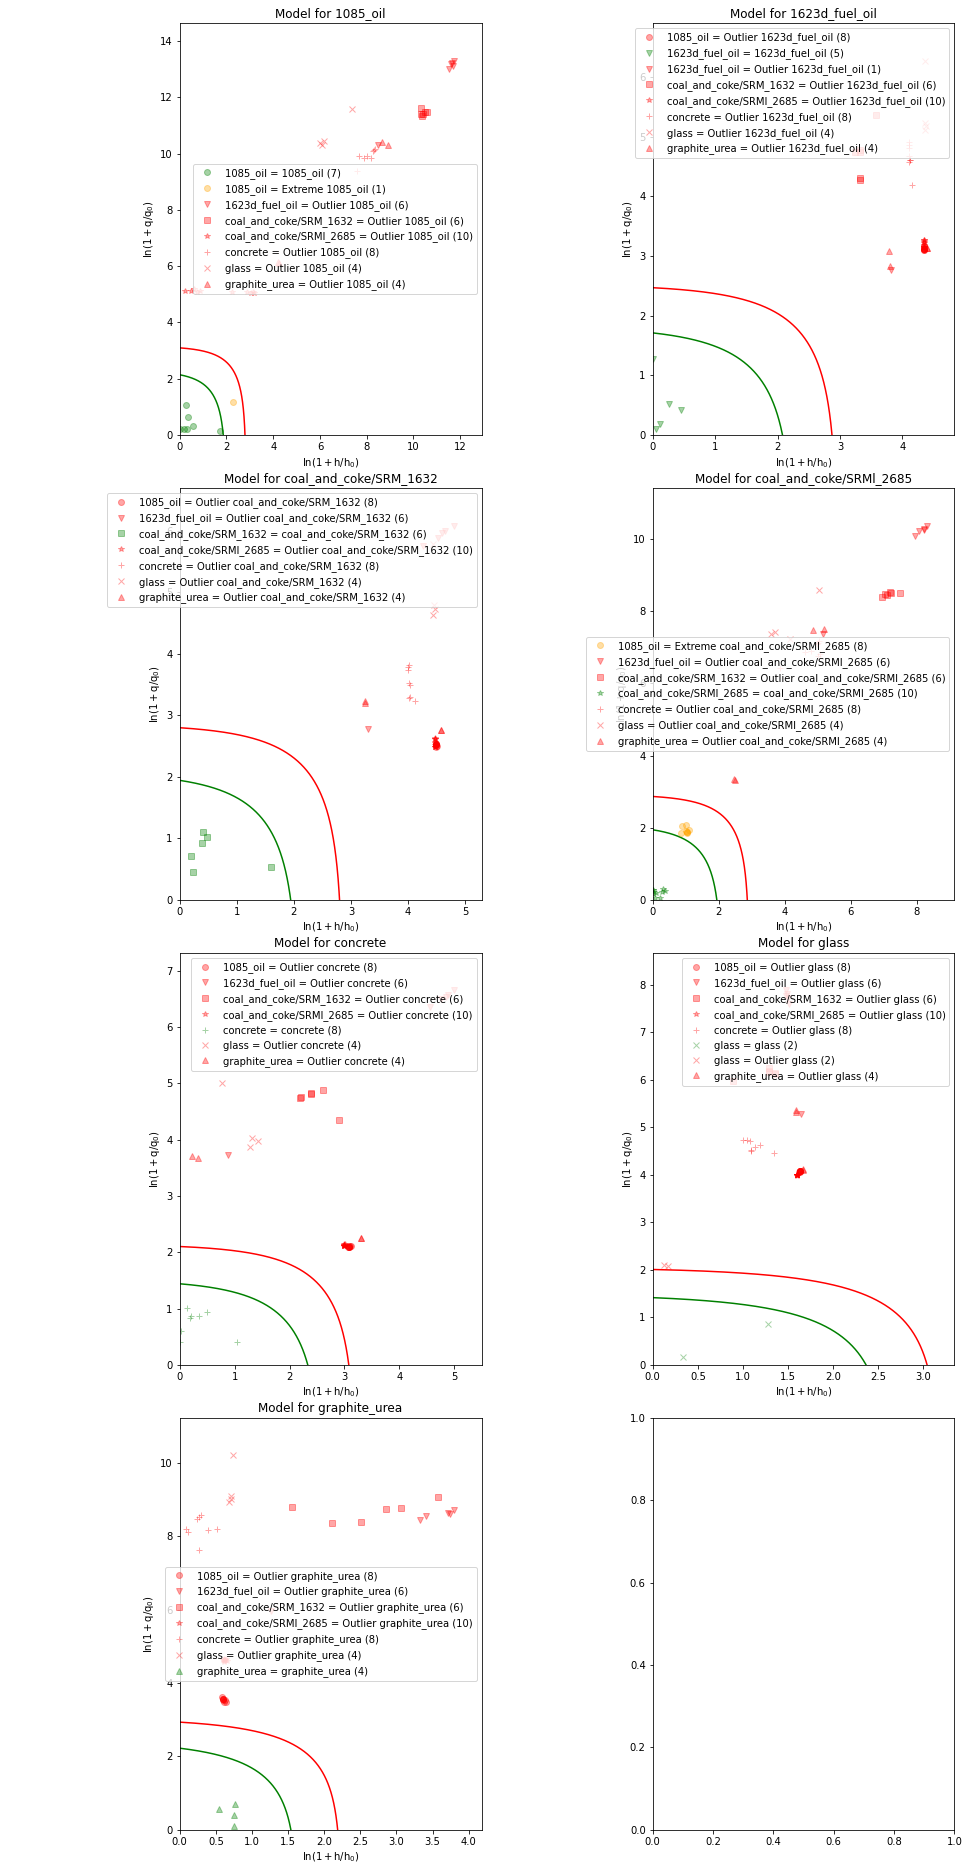

In [374]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,30))
for ax, target in zip(axes.flatten(), models.keys()):
    models[target].best_estimator_.named_steps['simca'].model.visualize(X_test, y_test, ax=ax)
    ax.set_title('Model for {}'.format(target))
    ax.legend(loc='best')
plt.tight_layout()

## Explanations